In [1]:
import numpy as np
import sys
sys.path.insert(0, '/Library/Application Support/MWorks/Scripting/Python')
from mworks.data import MWKFile
import matplotlib.pyplot as plt
import matplotlib.style as style 
import pandas as pd
import pickle as pkl

In [257]:
style.use('seaborn-poster') 
style.use('seaborn-white')

In [4]:
# username = 'apiccato'
username = 'aidapiccato'
dir_path = '/Users/%s/PyCharmProjects/concentration/concentration-game-mworks' % username
subject_id = 0
subject_fn = '%s/meta/subject_%s.pkl' % (dir_path, subject_id)

In [5]:
## sync times 
ITI = 1
TRIAL_INIT = 2
FLIP_CARD_A = 3
FLIP_CARD_B = 4
FEEDBACK = 5
TRIAL_END = 6

In [309]:
class Unpack():    
    def __init__(self, fn, subject_fn):
        fpath = '/Users/%s/Documents/MWorks/Data' % username
        self.fn = fn
        self.subject_fn = subject_fn
        self.f =  MWKFile('%s/%s' % (fpath, fn))
        self.f.open()
        self.codec = self.f.codec
        self.codenames = ['card_b', 'card_a', 'selection_trial_index'] ## 'success', 'ignore', 'failure']
        self.start_sync_t, self.end_sync_t = self.get_sync_times()
        self.n_trials = len(self.start_sync_t)
        print('Collecting %d trials of data' % self.n_trials)
        self.avg_trial_dur = (self.end_sync_t - self.start_sync_t) / 10**6
        print('Average trial duration: %f seconds' % np.mean(self.avg_trial_dur))
        self.meta = self.get_meta()
        self.scalar = self.get_scalar_data()
        self.analog = self.get_analog_data()
    def get_meta(self): 
        meta_flat = {'block_index':[], 'grid': [], 'card_a': [], 'trial_index': [], 'n_pairs': [], 'grid_dims': [], 'inv_grid': [],}
        with open(subject_fn, 'rb') as f:
            meta = pkl.load(f)
        for block_index, block in enumerate(meta):
            inv_grid = block['inv_grid']
            grid_dims = block['grid_dims']
            n_pairs = block['n_pairs']
            grid = block['grid']
            for trial_index, card_a in enumerate(block['trials']):
                meta_flat['block_index'].append(block_index)
                meta_flat['trial_index'].append(trial_index)
                meta_flat['n_pairs'].append(n_pairs)
                meta_flat['grid_dims'].append(grid_dims)
                meta_flat['inv_grid'].append(inv_grid)
                meta_flat['grid'].append(grid)
                meta_flat['card_a'].append(card_a)
        return pd.DataFrame(meta_flat)
    
    def get_analog_data(self):
        data_analog = {'location': [], 'img': [], 'trial': [], 'time': [], 'selected': []} 
        
        for t in range(self.n_trials):
            start_t, end_t = np.long(self.start_sync_t[t]), np.long(self.end_sync_t[t])
            trial_events = self.f.get_events(codes=['sync'], time_range=[start_t, end_t])
            trial_events = np.asarray([[e.code, e.time, e.data] for e in trial_events])
            card_a_t = trial_events[np.where(trial_events[:, 2] == FLIP_CARD_A)[0], 1]
            card_b_t = trial_events[np.where(trial_events[:, 2] == FLIP_CARD_B)[0], 1]
            
            data_analog['location'].append(self.scalar['card_a'])
            data_analog['img'].append(self.scalar['card_a_img'])
            data_analog['trial'].append(t)
            data_analog['time'].append(card_a_t)
            data_analog['selected'].append(False)
            
            
            data_analog['location'].append(self.scalar['card_b'][t])
            data_analog['img'].append(self.scalar['card_b_img'])
            data_analog['trial'].append(t)
            data_analog['time'].append(card_b_t)
            data_analog['selected'].append(True)
            
        data_analog = pd.DataFrame(data_analog)
            
                                               
        return data_analog


            
    def get_scalar_data(self):
        data_scalar = {'dur': [], 'card_a_img': [], 'card_b_img': [],  'card_c': [], 'dist_a_b': [], 'dist_b_c': []}        
        for c in self.codenames:
            data_scalar[c] = []
        for c in self.meta.columns:
            if c != 'card_a':
                data_scalar[c] = []
        for trial in range(self.n_trials):            
            start_t, end_t = np.long(self.start_sync_t[trial]), np.long(self.end_sync_t[trial])
            trial_events = self.f.get_events(codes = self.codenames, time_range=[start_t, end_t])
            trial_events = np.asarray([[e.code, e.time, e.data] for e in trial_events])         
            # trial duration        
            data_scalar['dur'].append((end_t - start_t)/10**6)        
            for ci, c in enumerate(self.codenames): # currently this is only selecting card_b                
                code = self.f.reverse_codec[c]
                code_events = trial_events[np.where(trial_events[:, 0] == code)[0], 2]
                data_scalar[c].append(code_events[0])                   
            for ci, c in enumerate(self.meta.columns):
                if c != 'card_a':
                    data_scalar[c].append(self.meta.loc[trial][c]) 
            if self.meta.loc[trial]['trial_index'] != data_scalar['selection_trial_index'][trial] or self.meta.loc[trial]['card_a'] != data_scalar['card_a'][trial]:
                print(self.meta.loc[trial]['card_a'])
                print(data_scalar['card_a'][trial])
                
                print("Trial %d: meta and event stream are not aligned" % trial) 
                break
            card_a = data_scalar['card_a'][trial]
            card_b = data_scalar['card_b'][trial]
            grid = data_scalar['grid'][trial]
            data_scalar['card_a_img'].append(data_scalar['grid'][trial][card_a])
            data_scalar['card_b_img'].append(data_scalar['grid'][trial][card_b])
            match = np.where(grid == grid[card_a])[0] 
            card_c = match[match != card_a]
#             print(card_c[0])
            data_scalar['card_c'].append(card_c[0])
            # distance between locations of card a and b
            data_scalar['dist_a_b'].append(self.get_dist(card_a, card_b, data_scalar['grid_dims'][trial]))
            # distance between locations of card b and correct card
            data_scalar['dist_b_c'].append(self.get_dist(card_a, card_c, data_scalar['grid_dims'][trial]))
            
        data_scalar['rt'] = self.get_reaction_times() 
        
        data_scalar = pd.DataFrame(data_scalar)
        return data_scalar
    
    def get_sync_times(self): 
        sync_events = self.f.get_events(codes=['sync'])
        sync_events = np.asarray([[e.data, e.time] for e in sync_events])        
        end_sync_t = sync_events[np.where(sync_events[:, 0] == TRIAL_END)[0], 1]
        start_sync_t = sync_events[np.where(sync_events[:, 0] == TRIAL_INIT)[0], 1]
        start_sync_t = start_sync_t[:len(end_sync_t)]
        return start_sync_t, end_sync_t
    
    def get_dist(self, card_a, card_b, grid_dims): 
        card_a_loc = np.asarray([np.floor(card_a/grid_dims[1]), card_a%grid_dims[1]])
        card_b_loc = np.asarray([np.floor(card_b/grid_dims[1]), card_b%grid_dims[1]])
        return np.linalg.norm(card_a_loc - card_b_loc)
    
    def get_reaction_times(self):
        rts = []
        for trial in range(self.n_trials):
            start_t, end_t = np.long(self.start_sync_t[trial]), np.long(self.end_sync_t[trial])
            sync = self.f.get_events(codes = ['sync'], time_range=[start_t, end_t])
            sync = np.asarray([[e.data, e.time] for e in sync])                
            flip_card_a = sync[np.where(sync[:, 0] == FLIP_CARD_A)[0], 1]
            flip_card_b = sync[np.where(sync[:, 0] == FLIP_CARD_B)[0], 1]
            rt = np.long(flip_card_b) - np.long(flip_card_a)
            rts.append(rt/10**6)
        return rts

In [310]:
fn = "aidapiccato-concentration-20200121-082627.mwk2"
unpack = Unpack(fn, subject_fn)

Average trial duration: 1.460817 seconds
27
3
Trial 0: meta and event stream are not aligned


ValueError: arrays must all be same length

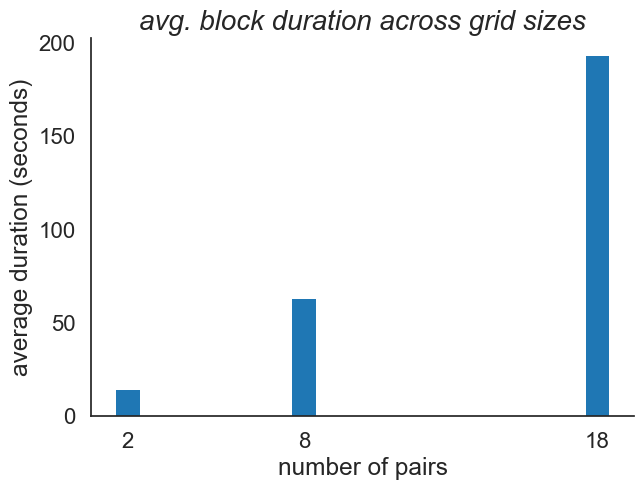

In [319]:
# duration of block averaged across grid sizes
block_avg_dur = unpack.scalar.groupby('n_pairs')['dur'].sum()/unpack.scalar.groupby('n_pairs')['block_index'].nunique()
f, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=100)
ax.bar(block_avg_dur.keys(), block_avg_dur)
ax.set_xticks(block_avg_dur.keys())
ax.set_xlabel('number of pairs')
ax.set_ylabel('average duration (seconds)')
ax.set_title('avg. block duration across grid sizes')
prettify(ax)
plt.show()

In [321]:
n_repeats = 4
((25 + 75 + 200) * n_repeats)/60

20.0

***

### Plotting methods (TODO: move to separate utils file)

In [290]:
def prettify(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.title.set_style('italic')
    ax.title.set_size(20)